In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly
import plotly.offline as py
import datetime as dt 
from scipy import stats as st
import warnings
warnings.simplefilter('ignore')

In [44]:
df = pd.read_csv('purchases.csv')

In [45]:
# check the Nan 
df.isna().sum()

date_purchased    0
id_ticket         0
id_user           0
city_of_event     0
revenue           4
is_free_ticket    0
dtype: int64

In [46]:
df.head()

,date_purchased,id_ticket,id_user,city_of_event,revenue,is_free_ticket
0,2019-09-21,13965092,39741238,5,0.0,True
1,2019-09-29,14043914,37767368,5,0.0,True
2,2019-10-20,14209374,36360650,5,0.0,True
3,2019-10-22,14220595,44256387,5,0.0,True
4,2019-10-26,14248234,44272538,5,0.0,True


In [47]:
# Only 4 missing values
df[df['revenue'].isna()]

,date_purchased,id_ticket,id_user,city_of_event,revenue,is_free_ticket
12587,2019-10-11,14121781,40837932,5,NaN,False
55202,2019-08-31,13827045,43590227,5,NaN,False
102632,2019-09-08,13875225,44088618,5,NaN,False
238104,2019-10-21,14213572,41063123,6,NaN,False


##### Since they are Paid tickets,it is unlikely to have 0 revenue. We could either replace them by average revenue, average revenue by purchased date or easily removed them.In this case, we removed them directly.

In [48]:
df = df.dropna()

In [49]:
# check types
df.dtypes

date_purchased     object
id_ticket           int64
id_user             int64
city_of_event       int64
revenue           float64
is_free_ticket       bool
dtype: object

#### Data Preparation:
* step 1: We label users by timeline. One group is for users who registered after Oct 1st. The other is for users who had purchased records before Oct 1st. 
* step 2: We compare purchase behavior in two groups (descriptive)
* step 3: Statistical analyse 


In [50]:
## firstly, we need to check whether some users stop using apps after Oct 1st, find them and remove from dataset
user_last_purchased = df.groupby(['id_user']).aggregate({'date_purchased':'max'}).reset_index()
user_removed = user_last_purchased[user_last_purchased['date_purchased']<'2019-10-01']['id_user']
df = df[df['id_user'].isin(user_removed)==False]
print ('Total {} users left this app before Oct 1st, and we kept {} users at this moment.'\
       .format(user_removed.shape[0],df['id_user'].nunique()))

Total 38927 users left this app before Oct 1st, and we kept 41272 users at this moment.


In [51]:
## secondly, we split current users into two groups: new/old registers
user_first_purchased = df.groupby(['id_user']).aggregate({'date_purchased':'min'}).reset_index()
#old_users = user_first_purchased[user_first_purchased['date_purchased']<'2019-10-01']['id_user']
new_users = user_first_purchased[user_first_purchased['date_purchased']>='2019-10-01']['id_user']

In [52]:
# We label them by Old=0 New= 1
df['is_new_user'] = (df['id_user'].isin(new_users)==True).astype(int)

In [53]:
# We concentrate on users behaviour after Oct 1st
df['is_after_oct'] = (df['date_purchased']>='2019-10-01').astype(int)

In [54]:
print ('We split activity users (after Oct 1st) into two groups, there are {} new users and {} are regular users'\
       .format(new_users.nunique(),(df['id_user'].nunique()-new_users.nunique())))

We split activity users (after Oct 1st) into two groups, there are 31721 new users and 9551 are regular users


In [55]:
df_2 = df.copy()

In [56]:
# transform the time
df_2['date_purchased'] = pd.to_datetime(df_2['date_purchased'])
df_2['weekday'] = df_2['date_purchased'].dt.weekday_name
df_2['month'] = df_2['date_purchased'].dt.month
#df_2['day'] = df_2['date_purchased'].dt.day

##### Comparing purchase behaviour 
* We compare the regular users purchase behavior before and after October, we assume those possible changes may benefit from/casued by loyalty programs.
* We also compare the new users' consumption behavior to regular users' (after October 1st).

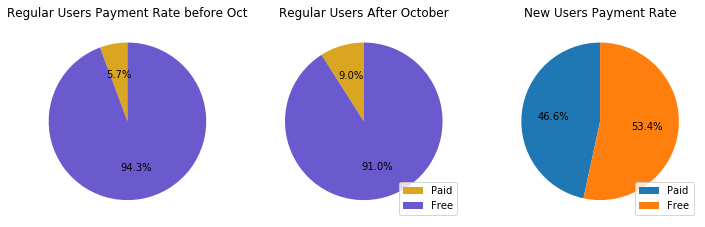

In [57]:
colors = ['goldenrod','slateblue']
f,x = plt.subplots(1,3,figsize=(12,7))
plt.subplot(1, 3, 1)
x1 = df_2[(df_2['is_after_oct']==0)&(df_2['is_new_user']==0)]['is_free_ticket'].value_counts().sort_values()
plt.pie(x1,colors = colors, startangle=90,autopct='%1.1f%%')
plt.title('Regular Users Payment Rate before Oct')
plt.subplot(1, 3, 2)
x2 = df_2[(df_2['is_after_oct']==1)&(df_2['is_new_user']==0)]['is_free_ticket'].value_counts().sort_values()
plt.pie(x2,colors = colors, startangle=90,autopct='%1.1f%%')
plt.title('Regular Users After October')
plt.legend(['Paid','Free'],loc='lower right')
plt.subplot(1, 3, 3)
x3 = df_2[df_2['is_new_user']==1]['is_free_ticket'].value_counts().sort_values()
plt.pie(x3,startangle=90,autopct='%1.1f%%')
plt.title('New Users Payment Rate')
plt.legend(['Paid','Free'],loc='lower right')
plt.show()

##### Now, let s see how the revenue distributed.

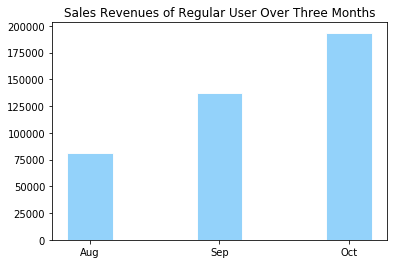

In [58]:
regular_revenue = df_2[df_2['is_new_user']==0].groupby(['month'])['revenue'].sum().reset_index()
x = ['Aug','Sep','Oct']
y = regular_revenue['revenue'].values.round(2)[:3]
plt.bar(x, y, alpha=0.9, width = 0.35, facecolor = 'lightskyblue', edgecolor = 'white')
plt.xticks(x)
plt.title("Sales Revenues of Regular User Over Three Months")
plt.show()

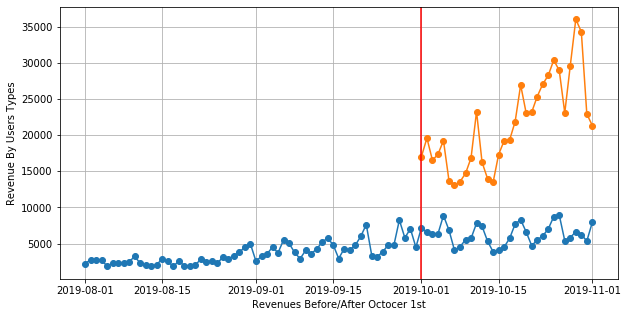

In [59]:
plt.figure(figsize=(10,5))
plt.plot(df_2[df_2['is_new_user']==0].groupby('date_purchased')['revenue'].sum(),'o-')
plt.plot(df_2[df_2['is_new_user']==1].groupby('date_purchased')['revenue'].sum(),'o-')
plt.axvline(x='2019-10-01', color='r', linestyle='-')
plt.xlabel('Revenues Before/After Octocer 1st')
plt.ylabel('Revenue By Users Types')
plt.grid(True)
plt.show()

##### Weekdays 

In [60]:
# daily purchase for regular users
purchaseFree = df_2[(df_2['is_new_user']==0)&(df_2['is_after_oct']==1)&(df_2['is_free_ticket']==True)].groupby('weekday')['id_user'].count()
purchaseFree.name = 'free'
purchasePaid = df_2[(df_2['is_new_user']==0)&(df_2['is_after_oct']==1)&(df_2['is_free_ticket']==False)].groupby('weekday')['id_user'].count()
purchasePaid.name = 'paid'
daily_purchase = pd.concat([purchaseFree,purchasePaid],axis=1)
# daily purchase for new users 
new_purchaseFree = df_2[(df_2['is_new_user']==1)&(df_2['is_free_ticket']==True)].groupby('weekday')['id_user'].count()
new_purchaseFree.name = 'free'
new_purchasePaid = df_2[(df_2['is_new_user']==1)&(df_2['is_free_ticket']==False)].groupby('weekday')['id_user'].count()
new_purchasePaid.name = 'paid'
new_daily_purchase = pd.concat([new_purchaseFree,new_purchasePaid],axis=1)

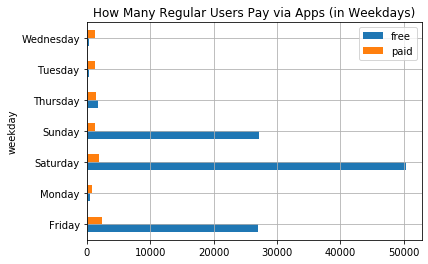

In [61]:
daily_purchase.sort_index(ascending=True).plot(kind='barh',label=u'free',grid=True)
plt.title('How Many Regular Users Pay via Apps (in Weekdays)')
plt.show()

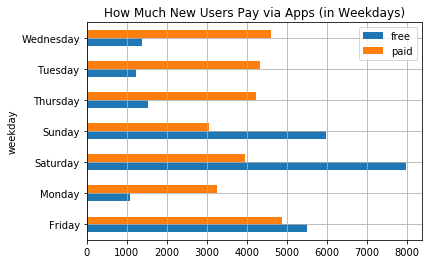

In [62]:
new_daily_purchase.sort_index(ascending=True).plot(kind='barh',label=u'free',grid=True)
plt.title('How Much New Users Pay via Apps (in Weekdays)')
plt.show()

In [63]:
df_2.head()

,date_purchased,id_ticket,id_user,city_of_event,revenue,is_free_ticket,is_new_user,is_after_oct,weekday,month
0,2019-09-21,13965092,39741238,5,0.0,True,0,0,Saturday,9
2,2019-10-20,14209374,36360650,5,0.0,True,0,1,Sunday,10
3,2019-10-22,14220595,44256387,5,0.0,True,1,1,Tuesday,10
4,2019-10-26,14248234,44272538,5,0.0,True,1,1,Saturday,10
5,2019-09-02,13839419,35925622,5,0.0,True,0,0,Monday,9


#### Event City

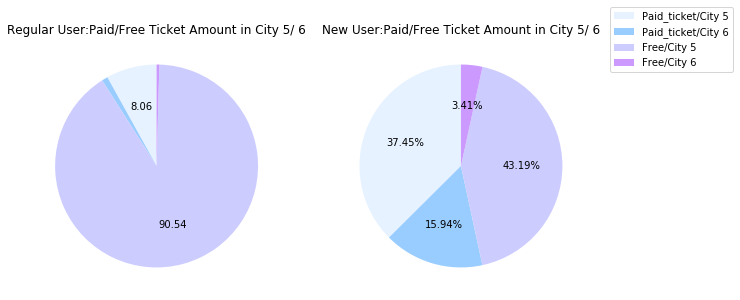

In [64]:
f,x = plt.subplots(1,3,figsize=(10,7))
colors = ['#e6f2ff','#99ccff','#ccccff','#cc99ff']
counts_reg = df_2[(df_2['is_new_user']==0)&(df_2['is_after_oct']==1)].groupby(['is_free_ticket'])['city_of_event'].value_counts(sort=True)

def cha_autopct(pct):
    return ('%.2f' % pct) if pct > 5 else ''
plt.subplot(1, 2, 1)
plt.pie(counts_reg,startangle=90,autopct=cha_autopct,colors=colors)
plt.title('Regular User:Paid/Free Ticket Amount in City 5/ 6')

plt.subplot(1, 2, 2)
labels = ['Paid_ticket/City 5','Paid_ticket/City 6','Free/City 5','Free/City 6']
counts_new = df_2[df_2['is_new_user']==1].groupby(['is_free_ticket'])['city_of_event'].value_counts(sort=True)
plt.pie(counts_new,startangle=90,autopct='%1.2f%%',colors=colors)
plt.title('New User:Paid/Free Ticket Amount in City 5/ 6')
plt.legend(labels,loc=6,bbox_to_anchor=(1.05,1.0),borderaxespad = 1.)
plt.show()



In [65]:
counts_reg

is_free_ticket  city_of_event
False           5                  9524
                6                  1128
True            5                106949
                6                   519
Name: city_of_event, dtype: int64

In [66]:
counts_new

is_free_ticket  city_of_event
False           5                19827
                6                 8439
True            5                22866
                6                 1806
Name: city_of_event, dtype: int64

#### But we did not consider other possible reasons may motivate new users purchase more, such as new register coupons and so on.

##### Statistical Analysis

In [67]:
# Reorganize dataset by key information only
df_3 = df_2.copy()
# prepare dummy var
df_3 = df_3.join(pd.get_dummies(df_3['is_free_ticket']))
df_3.rename(columns={False:'Paid_ticket',True:'Free_ticket'},inplace=True)

In [68]:
# remove historical records before Oct
df_3 = df_3[df_3['is_after_oct']==1]

In [69]:
# transform by aggragate USERS'PURCHASE by date
df_3 = df_3.groupby(['id_user']).aggregate({'id_ticket':'count','revenue':'sum','Paid_ticket':'sum','Free_ticket':'sum'}).reset_index()

In [70]:
df_3.rename(columns={'id_ticket':'id_ticket_amount'},inplace=True)
df_3['Ratio_of_Paid'] = df_3['Paid_ticket']/(df_3['id_ticket_amount'])
df_3['id_revenue'] = df_3['revenue']/df_3['id_ticket_amount']
df_3['is_new_user'] = (df_3['id_user'].isin(new_users)==True).astype(int)

In [71]:
df_3.head()

,id_user,id_ticket_amount,revenue,Paid_ticket,Free_ticket,Ratio_of_Paid,id_revenue,is_new_user
0,242,1,0.000000,0,1,0.0,0.000000,1
1,578,2,244.178955,2,0,1.0,122.089477,0
2,1817,1,0.000000,0,1,0.0,0.000000,0
3,3658,1,4.334950,1,0,1.0,4.334950,1
4,4442,1,29.509380,1,0,1.0,29.509380,1


##### Who bought more

In [72]:
df_3[df_3['Paid_ticket']==df_3['Paid_ticket'].max()]

,id_user,id_ticket_amount,revenue,Paid_ticket,Free_ticket,Ratio_of_Paid,id_revenue,is_new_user
16224,42702677,110,4184.835901,110,0,1.0,38.043963,0


In [73]:
# all users, who bought more
df_3.nlargest(10, 'Paid_ticket')

,id_user,id_ticket_amount,revenue,Paid_ticket,Free_ticket,Ratio_of_Paid,id_revenue,is_new_user
16224,42702677,110,4184.835901,110,0,1.000000,38.043963,0
15230,42460245,32,604.818906,29,3,0.906250,18.900591,0
26597,44177513,28,616.267073,28,0,1.000000,22.009538,1
12718,41696748,24,947.563278,24,0,1.000000,39.481803,0
17767,43087898,25,340.786482,24,1,0.960000,13.631459,0
394,9635343,24,192.216349,23,1,0.958333,8.009015,0
28697,44200840,23,1893.718609,23,0,1.000000,82.335592,1
348,7718547,24,336.192782,22,2,0.916667,14.008033,0
14212,42211235,23,203.355855,22,1,0.956522,8.841559,0
18442,43191427,27,626.485877,22,5,0.814815,23.203181,0


In [74]:
# all users, who bought more
df_3.nlargest(10, 'revenue')

,id_user,id_ticket_amount,revenue,Paid_ticket,Free_ticket,Ratio_of_Paid,id_revenue,is_new_user
16224,42702677,110,4184.835901,110,0,1.000000,38.043963,0
28697,44200840,23,1893.718609,23,0,1.000000,82.335592,1
22201,43842865,16,1792.806900,14,2,0.875000,112.050431,0
32428,44240970,5,1461.283573,5,0,1.000000,292.256715,1
726,19387117,14,1354.095362,13,1,0.928571,96.721097,0
38996,44288753,1,1058.210860,1,0,1.000000,1058.210860,1
23533,44066723,12,1051.202958,12,0,1.000000,87.600246,0
12718,41696748,24,947.563278,24,0,1.000000,39.481803,0
2030,35318060,22,914.883192,19,3,0.863636,41.585600,0
31218,44230178,1,846.815985,1,0,1.000000,846.815985,1


#### Test in Regular User Group and New Unser Group
* We aim to test whether the revenues remain the same in each group

In [75]:
# Stats of Revenue 
revenue_stats = df_3.groupby('is_new_user')['revenue'].describe().reset_index()
revenue_stats

,is_new_user,count,mean,std,min,25%,50%,75%,max
0,0,9551.0,21.095595,63.965278,0.0,0.0,9.353568,24.956045,4184.835901
1,1,31721.0,21.650232,34.461780,0.0,0.0,13.122158,28.208937,1893.718609


In [76]:
# Stats of Id_revenue 
id_revenue_stats = df_3.groupby('is_new_user')['id_revenue'].describe().reset_index()
id_revenue_stats

,is_new_user,count,mean,std,min,25%,50%,75%,max
0,0,9551.0,9.056937,16.665214,0.0,0.0,1.431854,13.231430,325.448279
1,1,31721.0,18.005348,25.595834,0.0,0.0,11.517524,23.272745,1058.210860


In [77]:
# Stats of Ratio of Paid
ratio_stats = df_3.groupby('is_new_user')['Ratio_of_Paid'].describe().reset_index()
ratio_stats

,is_new_user,count,mean,std,min,25%,50%,75%,max
0,0,9551.0,0.458521,0.476758,0.0,0.0,0.097561,1.0,1.0
1,1,31721.0,0.719825,0.441541,0.0,0.0,1.000000,1.0,1.0


* NUll: revenue in regual groups equal to revenue in new groups
* ALTER: not equal

In [78]:
re_usr = df_3[df_3['is_new_user']==0]
new_usr = df_3[df_3['is_new_user']==1]#.sample(re_usr.shape[0])

In [79]:
import statsmodels.stats.weightstats as sw
re_usr1 = re_usr['revenue']
new_usr1 = new_usr['revenue']
z_score, p_value = sw.ztest(re_usr1, new_usr1, alternative='two-sided')
print('z-score:', z_score, '，p-value:', p_value)

z-score: -1.1019698757432312 ，p-value: 0.27047476822881633


In [80]:
re_usr2 = re_usr['id_revenue']
new_usr2 = new_usr['id_revenue']
import statsmodels.stats.weightstats as sw
z_score2, p_value2 = sw.ztest(re_usr2, new_usr2,alternative='two-sided')
print('z-score:', z_score2, '，p-value:', p_value2)

z-score: -32.174665991789425 ，p-value: 3.992093884605979e-227


#### Conclusion: "id_revenue" is significant

In [ ]:
## plotly graphs 
"""x = regular_revenue['revenue'].index
y = regular_revenue['revenue'].values.round(2)

# Use textposition='auto' for direct text
fig1 = go.Figure(data=[go.Bar(
            x=['Aug','Sep','Oct'],
            y=y,
            text=y,
            width=0.4,
            textposition='auto',
            marker=dict(color='lightblue'))])

fig1.data[0].marker.line.width = 1
fig1.data[0].marker.line.color = "black"
fig1.update_layout(yaxis=dict(title='Sales Revenue'),
                   title='Sales Revenues of Regular User Over Four Months',width=700,height=500,
                   xaxis=dict(title='Month'))
fig1.show()"""

In [ ]:
"""from plotly.subplots import make_subplots
fig = make_subplots(1, 2, specs=[[{'type':'domain'}, {'type':'domain'}]],
                    subplot_titles=['Regular User', 'New User'])
colors = ['#e6f2ff','#99ccff','#ccccff','#cc99ff']
counts_reg = df_2[(df_2['is_new_user']==0)&(df_2['is_after_oct']==1)].groupby(['is_free_ticket'])['city_of_event'].value_counts(sort=True)
labels = ['Paid_ticket/City 5','Paid_ticket/City 6','Free/City 5','Free/City 6']
values_reg = counts_reg.values
pie_reg = go.Pie(labels=labels, values=counts_reg, marker=dict(colors = colors,line=dict(color='#000000', width=1)))
#layout_paid = go.Layout(title='Paid Ticket Amount: New Users vs. Regular User')
fig.add_trace(pie_reg, 1, 1)

counts_new = df_2[df_2['is_new_user']==1].groupby(['is_free_ticket'])['city_of_event'].value_counts(sort=True)
values_new = counts_new.values

pie_new = go.Pie(labels=labels, values=counts_new, marker=dict(colors = colors,line=dict(color='#000000', width=1)))
#layout_pree = go.Layout(title='Paid Ticket Amount (Nov): New Users vs. Regular User')
fig.add_trace(pie_new, 1, 2)
#go.Figure(data=[pie], layout=layout)
fig.update_layout(title_text='New Users vs. Regular User:Paid/Free Ticket Amount')
fig.show()"""